Instructions: click restart and run all above. Figures will show once the entire notebook has finished running (will take a few minutes)

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
from tqdm import tqdm
from membranequant import *
%matplotlib notebook

# Investigating the effects of pixel noise on quantification

Here, I aim to investigate the effects that pixel noise has on our ability to quantify cytoplasmic and membrane concentrations from images. For the method to be useful across images with a range of signal intensities (which will have differing signal to noise ratios), it is crucial that there is no systematic effect of noise.

I will perform analysis on a single real image, and create a set of images with varying levels of synthetic noise.

### Load image

Loading an image of a PAR-2 Neon tagged embryo

In [2]:
path = '../test_datasets/dataset2_par2_neon/01/'
img = load_image(path + '/af_corrected.tif')
roi = np.loadtxt(path + '/ROI.txt')

### Create synthetic noisy images

Adding Gaussian noise to pixel values. We will test a few levels of pixel noise

<IPython.core.display.Javascript object>


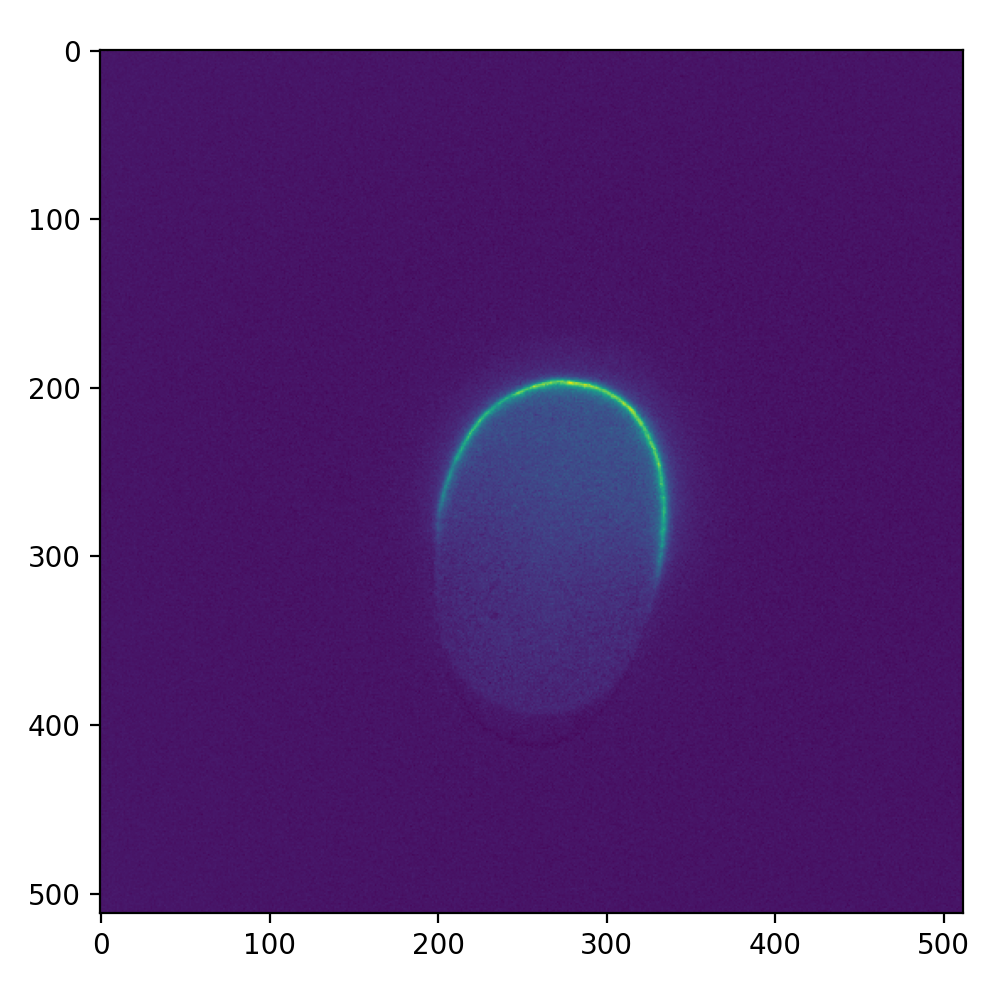

interactive(children=(IntSlider(value=0, description='noise', max=20000, step=1000), Output()), _dom_classes=(…

In [3]:
def fig_noisy_images():
    fig, ax = plt.subplots()
    @widgets.interact(noise=(0, 20000, 1000))
    def update(noise=0):
        noisy = img + np.random.normal(0, noise, img.shape)
        ax.clear()
        ax.imshow(noisy)
    fig.set_size_inches(5, 5)
    fig.tight_layout()
    
fig_noisy_images()

In [4]:
images = []
n = 5
noises = np.repeat(np.linspace(0,20000,11), n)
for noise in noises:
    images.append(img + np.random.normal(0, noise, img.shape))

### Run quantification

In [5]:
cytbg = np.loadtxt('saved_cyt_ref_profile.txt')
membg = np.loadtxt('saved_mem_ref_profile.txt')

iq = ImageQuant(images, roi=roi, thickness=50, periodic=True, rol_ave=20, iterations=1, lr=0.01, descent_steps=1000, uni_cyt=True, uni_mem=False, nfits=100, cytbg=cytbg, membg=membg)


In [6]:
iq.run()

100%|██████████| 1000/1000 [02:27<00:00,  6.78it/s]


Time elapsed: 149.19 seconds 


### Compile results

In [7]:
res = iq.compile_res()
grouped = res.groupby('Frame')
mems_post = grouped.apply(lambda x: bounded_mean_1d(x['Membrane signal'], [0.85, 0.15]))
cyts_post = grouped.apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], [0.85, 0.15]))  
mems_ant = grouped.apply(lambda x: bounded_mean_1d(x['Membrane signal'], [0.35, 0.65]))
cyts_ant = grouped.apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], [0.35, 0.65]))   

### View results

As we can see, whilst addition of pixel noise to images results in noise in the final quantification, there appears to be no systematic effect of pixel noise:

<IPython.core.display.Javascript object>


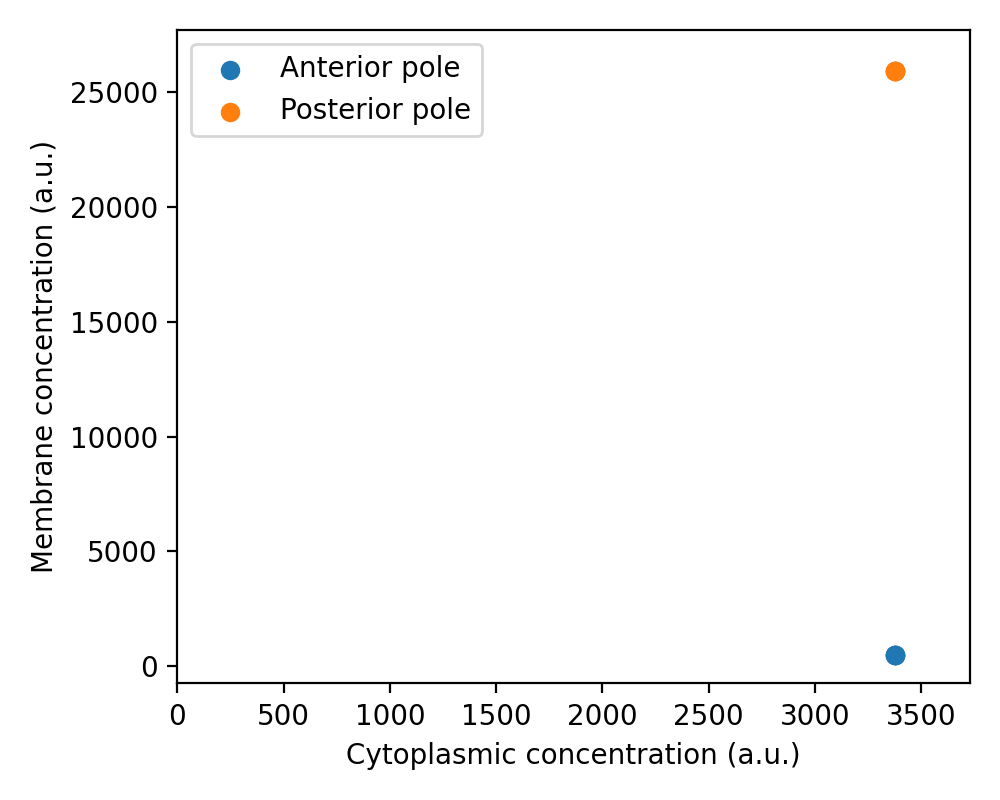

interactive(children=(IntSlider(value=0, description='noise', max=20000, step=2000), Output()), _dom_classes=(…

In [8]:
 def fig_cyt_mem():
    fig, ax = plt.subplots()
    @widgets.interact(noise=(0, 20000, 2000))
    def update(noise=0):
        ax.clear() 
        ax.scatter(cyts_ant[noises==noise], mems_ant[noises==noise], label='Anterior pole')
        ax.scatter(cyts_post[noises==noise], mems_post[noises==noise], label='Posterior pole')
        ax.set_xlim(min(np.min(cyts_post), np.min(cyts_ant), 0), max(np.max(cyts_post), np.max(cyts_ant)))
        ax.set_ylim(min(np.min(mems_post), np.min(mems_ant), 0), max(np.max(mems_post), np.max(mems_ant)))
        ax.set_xlabel('Cytoplasmic concentration (a.u.)')
        ax.set_ylabel('Membrane concentration (a.u.)')
        ax.legend()
    fig.set_size_inches(5, 4)
    fig.tight_layout()
    
fig_cyt_mem()

<IPython.core.display.Javascript object>


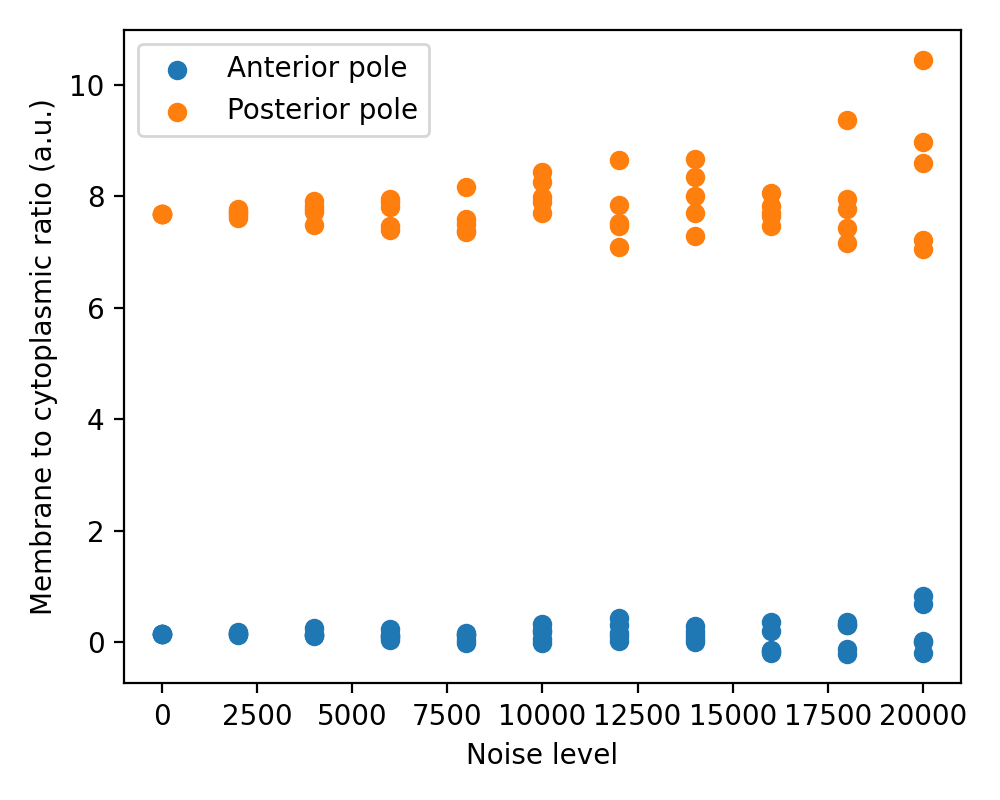

In [9]:
fig, ax = plt.subplots()
ax.scatter(noises, mems_ant / cyts_ant, label='Anterior pole')
ax.scatter(noises, mems_post / cyts_post, label='Posterior pole')
ax.set_xlabel('Noise level')
ax.set_ylabel('Membrane to cytoplasmic ratio (a.u.)')
ax.legend()
fig.set_size_inches(5, 4)
fig.tight_layout()